In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, \
     roc_curve, roc_auc_score

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_lmsc_brass_ok import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_lmsc_brass_ok.py`.

In [5]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [6]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

In [7]:
dependencies = {
    'recall': Recall
}

# fn = './keras_models/tenor_cnn_brass_ok/tenor_brass_ok_cnn_G.h5'
fn = './keras_models/tenor_cnn/tenor_cnn_G.h5'
model = load_model(fn, custom_objects=dependencies, compile=False)

In [10]:
# See: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(monitor='val_recall', patience=4)

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
NUM_EPOCHS = 24
BATCH_SIZE = 32
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE,
                    callbacks=[early_stopping])


Train on 4276 samples, validate on 1070 samples
Epoch 1/24
4276/4276 [==============================] - 147s 34ms/step - loss: 0.3154 - recall: 0.8995 - accuracy: 0.8714 - val_loss: 0.3038 - val_recall: 0.8580 - val_accuracy: 0.8794
Epoch 2/24
4276/4276 [==============================] - 151s 35ms/step - loss: 0.2516 - recall: 0.9039 - accuracy: 0.8934 - val_loss: 0.3094 - val_recall: 0.9117 - val_accuracy: 0.8748
Epoch 3/24
4276/4276 [==============================] - 151s 35ms/step - loss: 0.2101 - recall: 0.9151 - accuracy: 0.9130 - val_loss: 0.3837 - val_recall: 0.8196 - val_accuracy: 0.8682
Epoch 4/24
4276/4276 [==============================] - 151s 35ms/step - loss: 0.1835 - recall: 0.9337 - accuracy: 0.9280 - val_loss: 0.4093 - val_recall: 0.7466 - val_accuracy: 0.8449
Epoch 5/24
4276/4276 [==============================] - 141s 33ms/step - loss: 0.1496 - recall: 0.9429 - accuracy: 0.9420 - val_loss: 0.3919 - val_recall: 0.9386 - val_accuracy: 0.8776
Epoch 6/24
4276/4276 [====

In [12]:
loss, recall, accuracy = model.evaluate(x_test, y_test)
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# Recall: 86.70
# Accuracy: 90.13

1337/1337 [==============================] - 11s 9ms/step
Recall: 94.04
Accuracy: 87.96


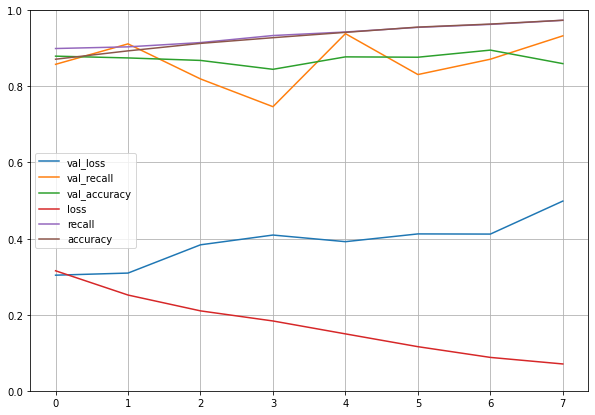

In [13]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
probas_pred = model.predict_proba(x_test)

In [15]:
y_true = [1 if x == '1' else 0 for x in y_test]

In [16]:
precision, recall, threshold = precision_recall_curve(y_true, probas_pred)

Text(0.5, 1.0, 'Precision-Recall Curve')

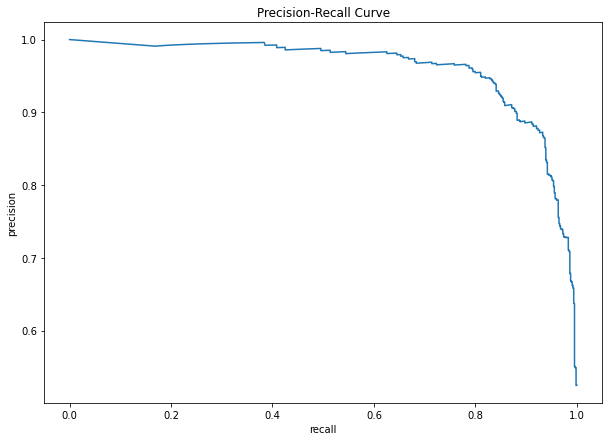

In [17]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")


In [18]:
fpr, tpr, threshold = roc_curve(y_true, probas_pred)
auc = roc_auc_score(y_true, probas_pred)

Text(0.5, 1.0, 'ROC Curve: AUC = 0.961')

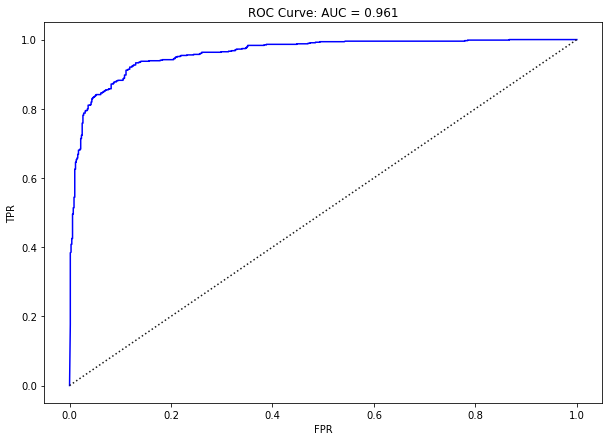

In [19]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 

In [20]:
fn = './keras_models/tenor_cnn_brass_ok/tenor_brass_ok_cnn_G.h5'
model.save(fn)